In [14]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Caminhos dos arquivos Excel
caminho_base = r"C:\Users\paulo\Desktop\Projeto Faculdade\BD_Completa_DATASUS.csv"
caminho_municipios = r"C:\Users\paulo\Desktop\Projeto Faculdade\BD_Municipios.xlsx"

In [16]:
# Carregar os dados dos municípios
df_municipios = pd.read_excel(
    caminho_municipios,
    engine="openpyxl",
    usecols=["CÓDIGO DO MUNICÍPIO - IBGE", "MUNICÍPIO - IBGE", "UF"],
    dtype={"CÓDIGO DO MUNICÍPIO - IBGE": str}
)

# Carregar a base principal
df = pd.read_csv(
    caminho_base,
    delimiter=";",  # Define o separador como vírgula
    usecols=["DTOBITO", "CODMUNNATU", "DTNASC", "SEXO", "RACACOR", "LOCOCOR", "CODMUNOCOR", "ASSISTMED", "CIRCOBITO"],
    dtype={"CODMUNNATU": str, "CODMUNOCOR": str},
    #nrows=50  # Limitando para rodar mais rápido
)

In [17]:
# Formatar datas

# Garantir que os valores estão como strings e remover espaços em branco
df["DTOBITO"] = df["DTOBITO"].astype(str).str.strip()
df["DTNASC"] = df["DTNASC"].astype(str).str.strip()

# Converter para datetime e manter as datas válidas
df["DTOBITO"] = pd.to_datetime(df["DTOBITO"], format="%d/%m/%Y", errors="coerce")
df["DTNASC"] = pd.to_datetime(df["DTNASC"], format="%d/%m/%Y", errors="coerce")

In [18]:
# Renomear coluna do DF de municípios para facilitar o merge
df_municipios.rename(columns={"CÓDIGO DO MUNICÍPIO - IBGE": "CODMUN"}, inplace=True)

# Realizar o LEFT JOIN duas vezes para obter a descrição do município para CODMUNNATU e CODMUNOCOR
df_resultado = df.merge(df_municipios, left_on="CODMUNNATU", right_on="CODMUN", how="left") \
                 .rename(columns={"MUNICÍPIO - IBGE": "MUNICIPIO_NATU", "UF": "UF_NATU"}) \
                 .drop(columns=["CODMUN"])

df_resultado = df_resultado.merge(df_municipios, left_on="CODMUNOCOR", right_on="CODMUN", how="left") \
                           .rename(columns={"MUNICÍPIO - IBGE": "MUNICIPIO_OCOR", "UF": "UF_OCOR"}) \
                           .drop(columns=["CODMUN"])

In [62]:
# Tratando Sexo
sexo_dict = {
    0: "Ignorado",
    1: "Masculino",
    2: "Feminino"
}

df_resultado["SEXO_DESC"] = df_resultado["SEXO"].map(sexo_dict)

#Tratando Racacor
racacor_dict = {
    1: "Branca",
    2: "Preta",
    3: "Amarela",
    4: "Parda",
    5: "Indígena",
    9: "Ignorado",
    None: "Ignorado"
}

df_resultado["RACACOR_DESC"] = df_resultado["RACACOR"].map(racacor_dict)

#Tratando Lococor
lococor_dict = {
    1: "Hospital",
    2: "Outro Estab. Saúde",
    3: "Domicílio",
    4: "Via Pública",
    5: "Outros",
    9: "Ignorado",
    None: "Ignorado"
}

df_resultado["LOCOCOR_DESC"] = df_resultado["LOCOCOR"].map(lococor_dict)

#Tratando Assistmed
assistmed_dict = {
    1: "Com assistência",
    2: "Sem assistência",
    9: "Ignorado",
    None: "Ignorado"
}

df_resultado["ASSISTMED_DESC"] = df_resultado["ASSISTMED"].map(assistmed_dict)

#Tratando Circobito
circobito_dict = {
    1: "Acidente",
    2: "Suicídio",
    3: "Homicídio",
    4: "Outros",
    9: "Ignorado",
    None: "Ignorado"
}

df_resultado["CIRCOBITO_DESC"] = df_resultado["CIRCOBITO"].map(circobito_dict)

In [20]:
#Criando colunas dos anos
df_resultado["ANO_NASC"] = df_resultado["DTNASC"].dt.year.astype("Int64")
df_resultado["ANO_OBITO"] = df_resultado["DTOBITO"].dt.year.astype("Int64")

#Criando colunas dos meses
df_resultado["MES_OBITO"] = df_resultado["DTOBITO"].dt.strftime("%B")

#Calculando idade
df_resultado["IDADE"] = df_resultado["ANO_OBITO"] - df_resultado["ANO_NASC"]

In [21]:
#Filtros

df_resultado = df_resultado[
    (df_resultado["UF_OCOR"] == "SP") & 
    (df_resultado["CIRCOBITO_DESC"] != "Ignorado") & 
    (df_resultado["CIRCOBITO_DESC"] != "Outros") & 
    (df_resultado["DTNASC"].notna())
]

In [24]:
df_resultado.head()

,DTOBITO,CODMUNNATU,DTNASC,SEXO,RACACOR,LOCOCOR,CODMUNOCOR,ASSISTMED,CIRCOBITO,MUNICIPIO_NATU,...,UF_OCOR,SEXO_DESC,RACACOR_DESC,LOCOCOR_DESC,ASSISTMED_DESC,CIRCOBITO_DESC,ANO_NASC,ANO_OBITO,MES_OBITO,IDADE
5,2023-02-14,355330,1947-09-14,1,1.0,1,355170,1.0,1.0,Tambaú,...,SP,Masculino,Branca,Hospital,Com assitência,Acidente,1947,2023,February,76
22,2023-02-14,352430,1971-03-03,1,4.0,4,352430,2.0,1.0,Jaboticabal,...,SP,Masculino,Parda,Via Pública,Sem assistência,Acidente,1971,2023,February,52
60,2023-01-01,354140,1948-03-22,1,1.0,1,352590,1.0,1.0,Presidente Prudente,...,SP,Masculino,Branca,Hospital,Com assitência,Acidente,1948,2023,January,75
80,2023-01-01,220840,1972-04-05,1,4.0,1,352590,1.0,1.0,Piripiri,...,SP,Masculino,Parda,Hospital,Com assitência,Acidente,1972,2023,January,51
216,2023-01-01,353740,1957-11-03,1,4.0,1,350280,1.0,1.0,Pereira Barreto,...,SP,Masculino,Parda,Hospital,Com assitência,Acidente,1957,2023,January,66


In [25]:
df_resultado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10933 entries, 5 to 1048517
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DTOBITO         10933 non-null  datetime64[ns]
 1   CODMUNNATU      10242 non-null  object        
 2   DTNASC          10933 non-null  datetime64[ns]
 3   SEXO            10933 non-null  int64         
 4   RACACOR         10862 non-null  float64       
 5   LOCOCOR         10933 non-null  int64         
 6   CODMUNOCOR      10933 non-null  object        
 7   ASSISTMED       9436 non-null   float64       
 8   CIRCOBITO       10933 non-null  float64       
 9   MUNICIPIO_NATU  10198 non-null  object        
 10  UF_NATU         10198 non-null  object        
 11  MUNICIPIO_OCOR  10933 non-null  object        
 12  UF_OCOR         10933 non-null  object        
 13  SEXO_DESC       10933 non-null  object        
 14  RACACOR_DESC    10933 non-null  object        
 15  LOCOC

In [26]:
df_resultado.describe()

,DTOBITO,DTNASC,SEXO,RACACOR,LOCOCOR,ASSISTMED,CIRCOBITO,ANO_NASC,ANO_OBITO,IDADE
count,10933,10933,10933.000000,10862.000000,10933.000000,9436.000000,10933.000000,10933.0,10933.0,10933.0
mean,2023-05-10 04:59:30.694228480,1973-07-26 19:57:54.874233952,1.254916,1.931965,2.537364,2.059983,1.497668,1973.077929,2023.0,49.922071
min,2023-01-01 00:00:00,1918-02-12 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1918.0,2023.0,0.0
25%,2023-03-05 00:00:00,1955-03-18 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1955.0,2023.0,31.0
50%,2023-05-09 00:00:00,1976-12-04 00:00:00,1.000000,1.000000,3.000000,2.000000,1.000000,1976.0,2023.0,47.0
75%,2023-07-15 00:00:00,1992-05-11 00:00:00,2.000000,4.000000,4.000000,2.000000,2.000000,1992.0,2023.0,68.0
max,2023-09-18 00:00:00,2023-09-15 00:00:00,2.000000,5.000000,9.000000,9.000000,3.000000,2023.0,2023.0,105.0
std,NaN,NaN,0.435834,1.338718,1.474505,2.054686,0.762815,23.212641,0.0,23.212641


In [27]:
df_resultado.isnull().sum()

DTOBITO              0
CODMUNNATU         691
DTNASC               0
SEXO                 0
RACACOR             71
LOCOCOR              0
CODMUNOCOR           0
ASSISTMED         1497
CIRCOBITO            0
MUNICIPIO_NATU     735
UF_NATU            735
MUNICIPIO_OCOR       0
UF_OCOR              0
SEXO_DESC            0
RACACOR_DESC         0
LOCOCOR_DESC         0
ASSISTMED_DESC       0
CIRCOBITO_DESC       0
ANO_NASC             0
ANO_OBITO            0
MES_OBITO            0
IDADE                0
dtype: int64

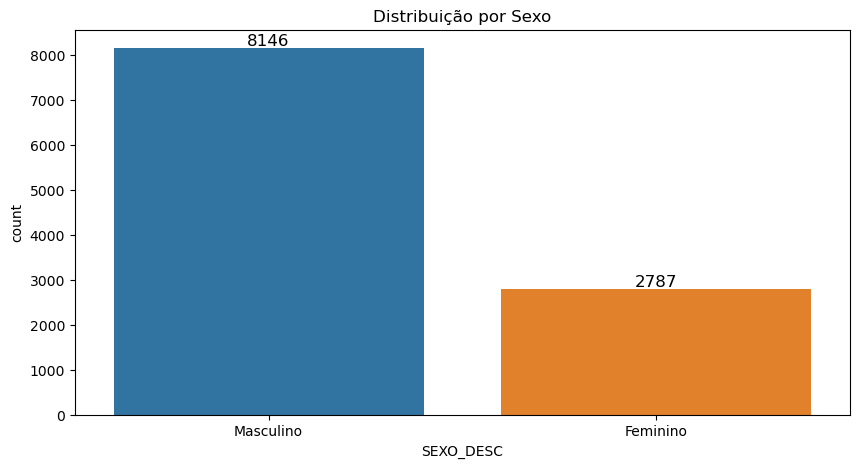

In [45]:
plt.figure(figsize=(10, 5))  # aumenta o espaço horizontal

ax = sns.countplot(x=df_resultado['SEXO_DESC'])
plt.title('Distribuição por Sexo')

# Adiciona os rótulos dentro das barras
for p in ax.patches:
    altura = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        altura + 1,
        int(altura),
        ha='center', va='bottom',
        color='black', fontsize=12
    )

plt.show()

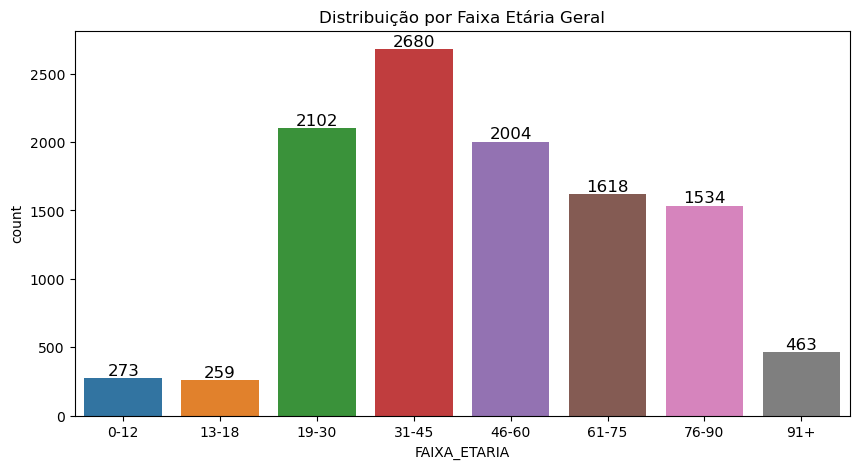

In [58]:
bins = [-1, 12, 18, 30, 45, 60, 75, 90, float('inf')]  # limites das faixas
labels = ['0-12', '13-18', '19-30', '31-45', '46-60', '61-75', '76-90', '91+']

df_resultado['FAIXA_ETARIA'] = pd.cut(df_resultado['IDADE'], bins=bins, labels=labels, right=True)

plt.figure(figsize=(10, 5))

ax = sns.countplot(x=df_resultado['FAIXA_ETARIA'].astype(str), order=labels)
plt.title('Distribuição por Faixa Etária Geral')

for p in ax.patches:
    altura = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        altura + 1,
        int(altura),
        ha='center', va='bottom',
        color='black', fontsize=12
    )

plt.show()

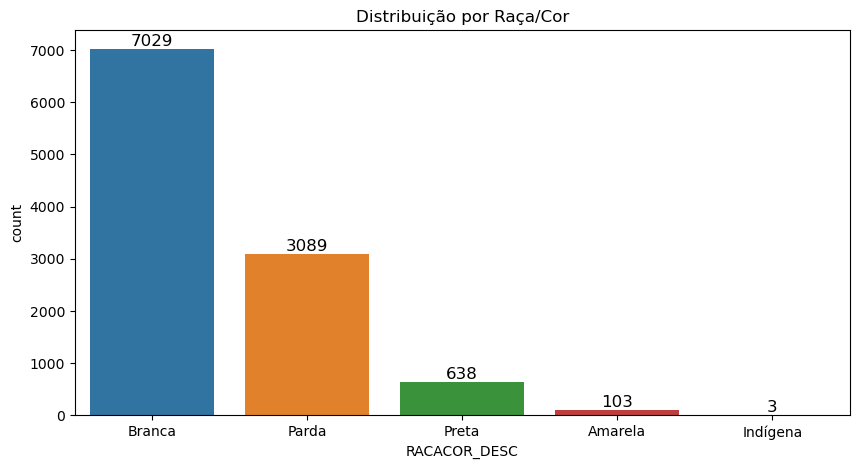

In [44]:
plt.figure(figsize=(10, 5))

# Remove registros com 'Ignorado' em RACACOR_DESC
filtro = df_resultado['RACACOR_DESC'] != 'Ignorado'
df_filtrado = df_resultado[filtro]

ax = sns.countplot(x=df_filtrado['RACACOR_DESC'])
plt.title('Distribuição por Raça/Cor')

# Adiciona os rótulos em cima das barras, com texto preto
for p in ax.patches:
    altura = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        altura + 1,
        int(altura),
        ha='center', va='bottom',
        color='black', fontsize=12
    )

plt.show()

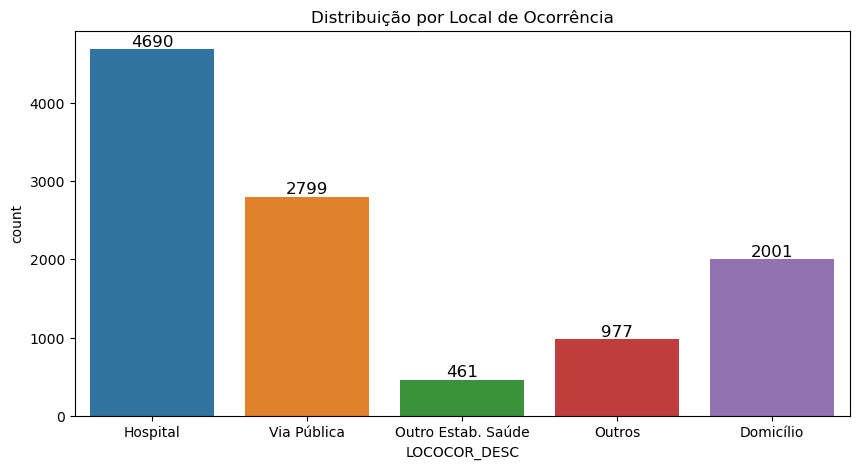

In [43]:
plt.figure(figsize=(10, 5))

# Remove registros com 'Ignorado' em LOCOCOR_DESC
filtro = df_resultado['LOCOCOR_DESC'] != 'Ignorado'
df_filtrado = df_resultado[filtro]

ax = sns.countplot(x=df_filtrado['LOCOCOR_DESC'])
plt.title('Distribuição por Local de Ocorrência')

# Adiciona os rótulos em cima das barras, com texto preto
for p in ax.patches:
    altura = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        altura + 1,
        int(altura),
        ha='center', va='bottom',
        color='black', fontsize=12
    )

plt.show()

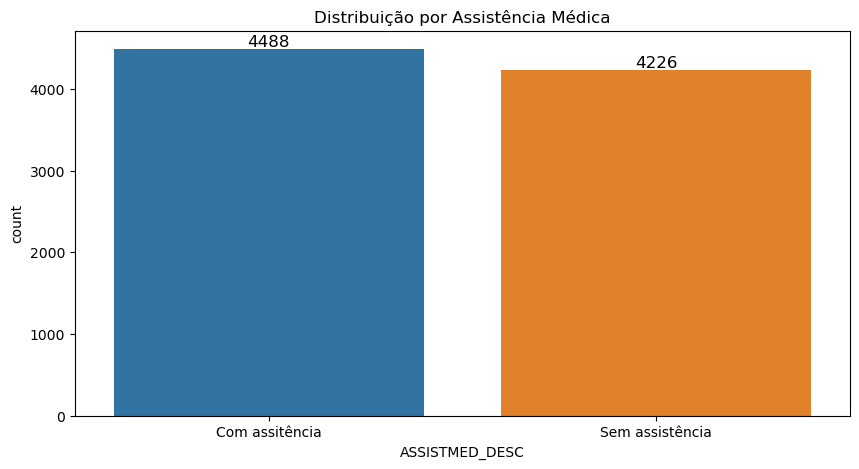

In [52]:
plt.figure(figsize=(10, 5))

# Remove registros com 'Ignorado' em LOCOCOR_DESC
filtro = df_resultado['ASSISTMED_DESC'] != 'Ignorado'
df_filtrado = df_resultado[filtro]

ax = sns.countplot(x=df_filtrado['ASSISTMED_DESC'])
plt.title('Distribuição por Assistência Médica')

# Adiciona os rótulos em cima das barras, com texto preto
for p in ax.patches:
    altura = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        altura + 1,
        int(altura),
        ha='center', va='bottom',
        color='black', fontsize=12
    )

plt.show()

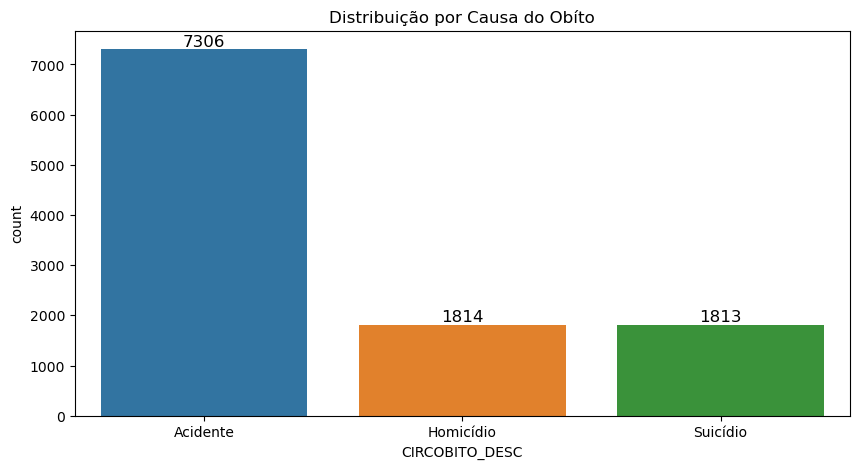

In [53]:
plt.figure(figsize=(10, 5))

# Remove registros com 'Ignorado' em LOCOCOR_DESC
filtro = df_resultado['CIRCOBITO_DESC'] != 'Ignorado'
df_filtrado = df_resultado[filtro]

ax = sns.countplot(x=df_filtrado['CIRCOBITO_DESC'])
plt.title('Distribuição por Causa do Obíto')

# Adiciona os rótulos em cima das barras, com texto preto
for p in ax.patches:
    altura = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        altura + 1,
        int(altura),
        ha='center', va='bottom',
        color='black', fontsize=12
    )

plt.show()

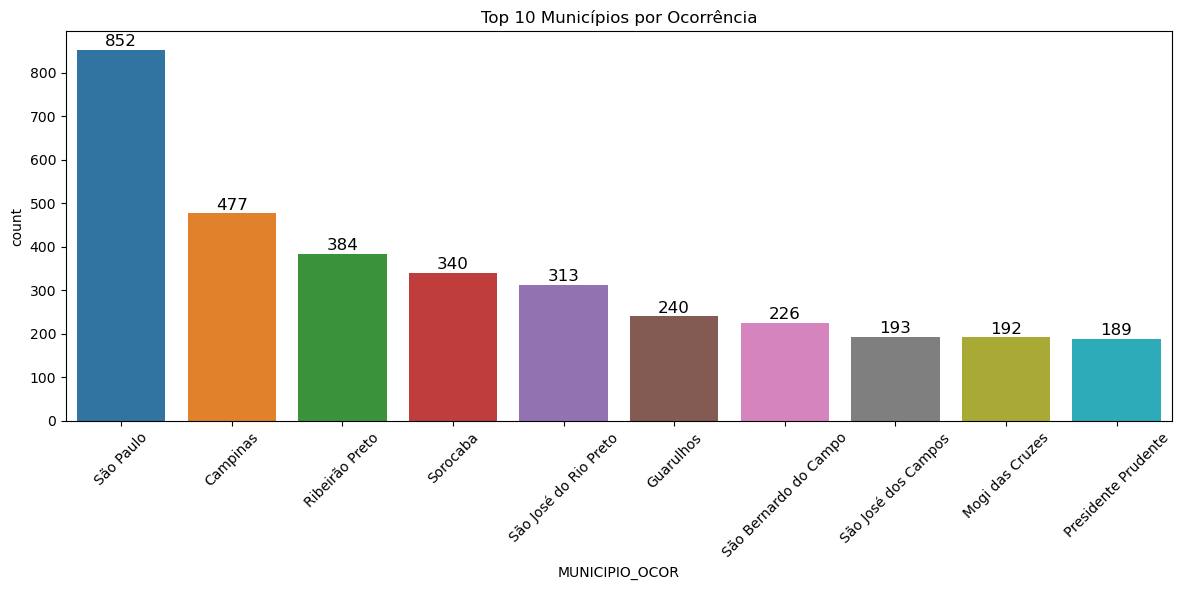

In [55]:
# 1. Conta as ocorrências por município
top10_municipios = df_resultado['MUNICIPIO_OCOR'].value_counts().nlargest(10).index

# 2. Filtra só os Top 10
df_top10 = df_resultado[df_resultado['MUNICIPIO_OCOR'].isin(top10_municipios)]

# 3. Define a ordem dos municípios no gráfico (por frequência)
ordem = df_top10['MUNICIPIO_OCOR'].value_counts().index

# 4. Plota o gráfico
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=df_top10['MUNICIPIO_OCOR'], order=ordem)
plt.title('Top 10 Municípios por Ocorrência')

# 5. Adiciona os rótulos em cima das barras
for p in ax.patches:
    altura = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        altura + 1,
        int(altura),
        ha='center', va='bottom',
        color='black', fontsize=12
    )

plt.xticks(rotation=45)  # gira os nomes se estiverem muito compridos
plt.tight_layout()
plt.show()


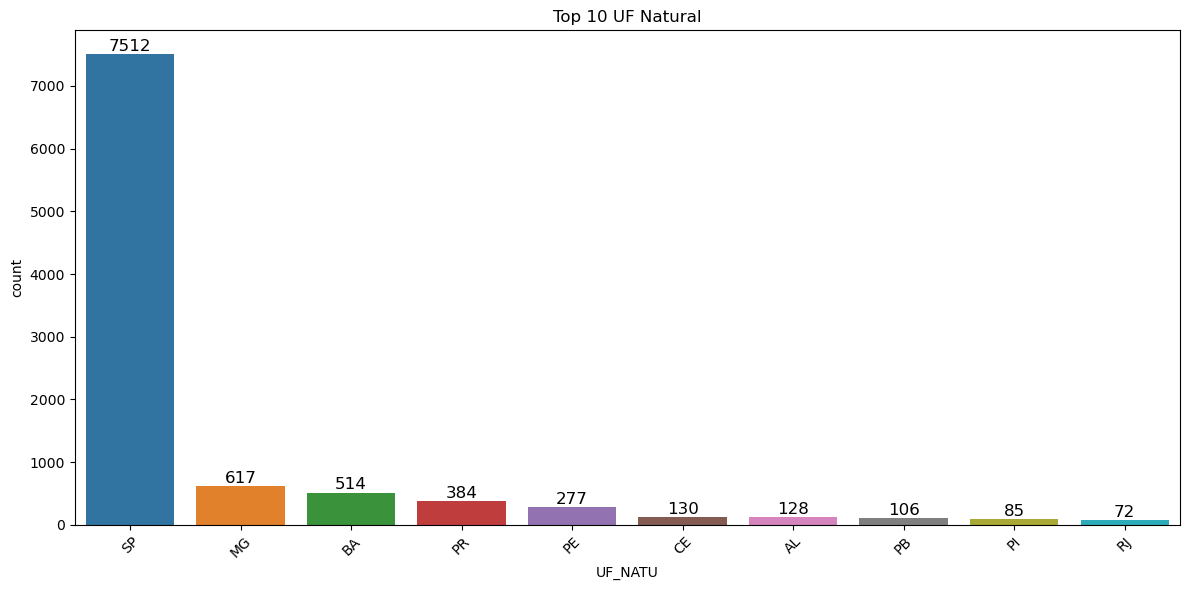

In [56]:
# 1. Conta as ocorrências por UF Natural
top10_municipios = df_resultado['UF_NATU'].value_counts().nlargest(10).index

# 2. Filtra só os Top 10
df_top10 = df_resultado[df_resultado['UF_NATU'].isin(top10_municipios)]

# 3. Define a ordem dos municípios no gráfico (por frequência)
ordem = df_top10['UF_NATU'].value_counts().index

# 4. Plota o gráfico
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=df_top10['UF_NATU'], order=ordem)
plt.title('Top 10 UF Natural')

# 5. Adiciona os rótulos em cima das barras
for p in ax.patches:
    altura = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        altura + 1,
        int(altura),
        ha='center', va='bottom',
        color='black', fontsize=12
    )

plt.xticks(rotation=45)  # gira os nomes se estiverem muito compridos
plt.tight_layout()
plt.show()

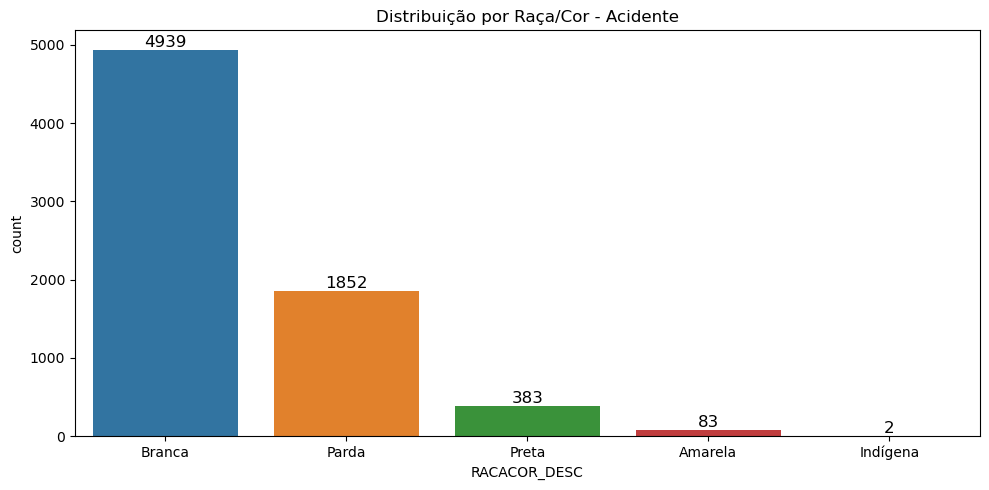

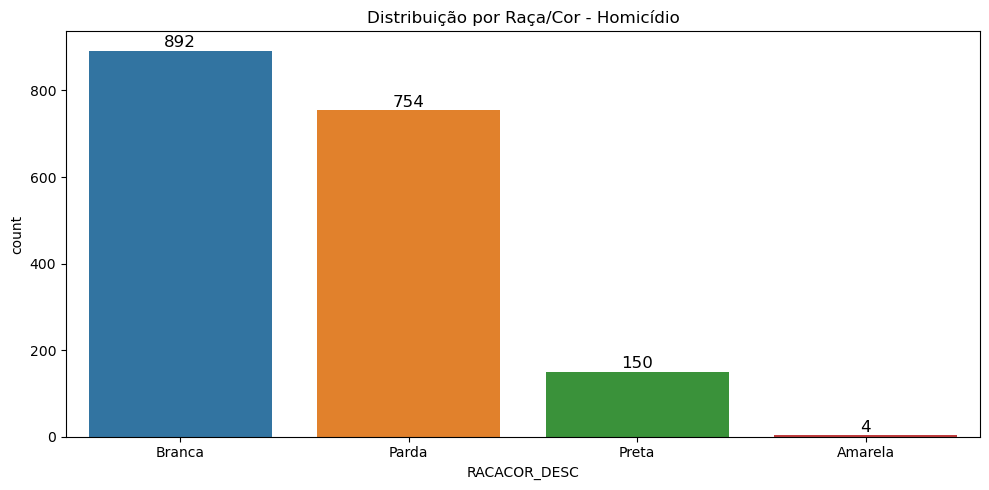

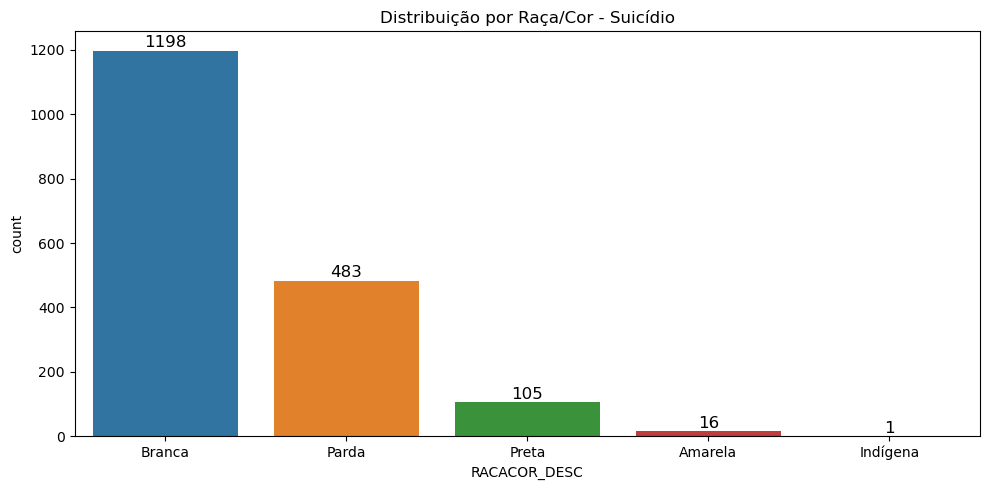

In [57]:
# Lista dos tipos de circunstâncias que queremos plotar
tipos_circunstancia = ['Acidente', 'Homicídio', 'Suicídio']

for tipo in tipos_circunstancia:
    plt.figure(figsize=(10, 5))

    # Filtra para o tipo de óbito e remove 'Ignorado' da raça/cor
    df_filtrado = df_resultado[
        (df_resultado['CIRCOBITO_DESC'] == tipo) &
        (df_resultado['RACACOR_DESC'] != 'Ignorado')
    ]

    ax = sns.countplot(x=df_filtrado['RACACOR_DESC'])
    plt.title(f'Distribuição por Raça/Cor - {tipo}')

    # Rótulos em cima das barras
    for p in ax.patches:
        altura = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2,
            altura + 1,
            int(altura),
            ha='center', va='bottom',
            color='black', fontsize=12
        )

    plt.tight_layout()
    plt.show()


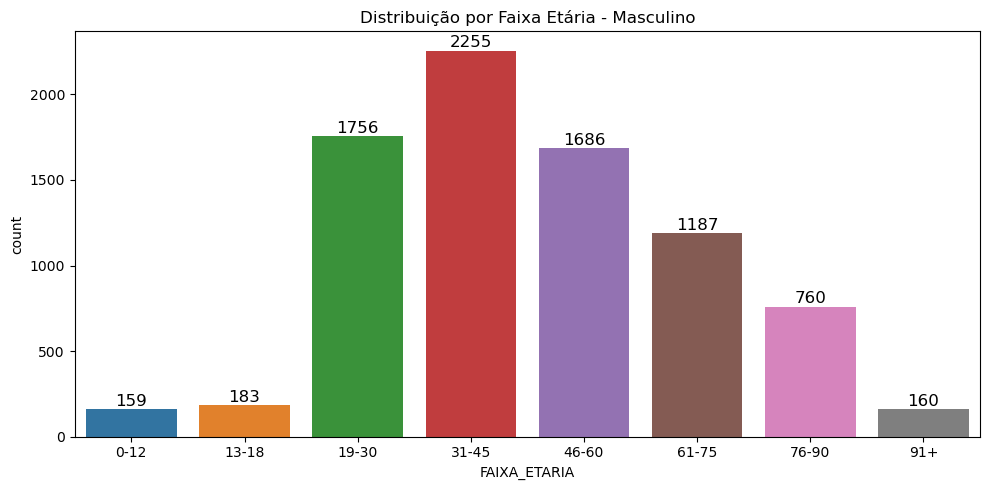

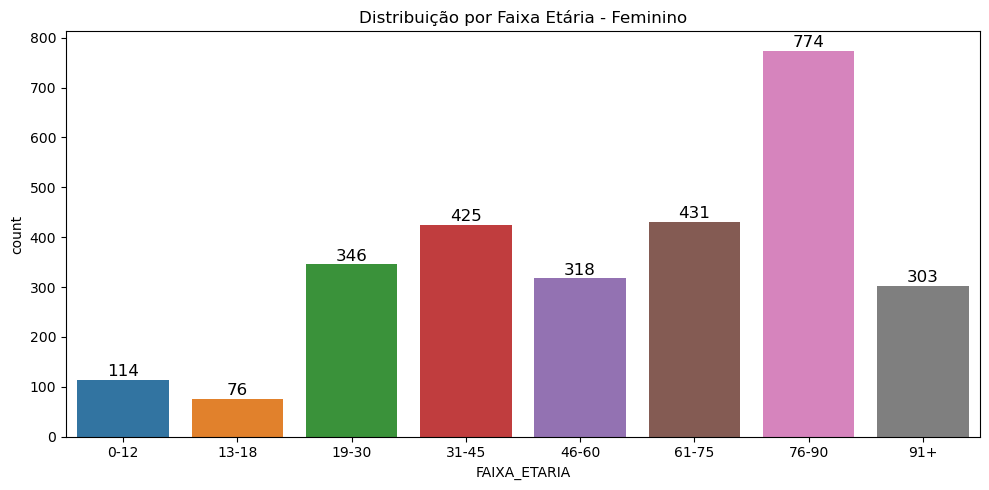

In [59]:
# Define as faixas etárias
bins = [-1, 12, 18, 30, 45, 60, 75, 90, float('inf')]
labels = ['0-12', '13-18', '19-30', '31-45', '46-60', '61-75', '76-90', '91+']

# Cria a nova coluna com faixa etária
df_resultado['FAIXA_ETARIA'] = pd.cut(
    df_resultado['IDADE'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

# Lista de sexos a plotar
sexos = ['Masculino', 'Feminino']

for sexo in sexos:
    plt.figure(figsize=(10, 5))

    # Filtra para o sexo atual
    df_filtrado = df_resultado[df_resultado['SEXO_DESC'] == sexo]

    ax = sns.countplot(
        x=df_filtrado['FAIXA_ETARIA'].astype(str),
        order=labels
    )
    plt.title(f'Distribuição por Faixa Etária - {sexo}')

    # Rótulos no topo das barras
    for p in ax.patches:
        altura = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2,
            altura + 1,
            int(altura),
            ha='center', va='bottom',
            color='black', fontsize=12
        )

    plt.tight_layout()
    plt.show()


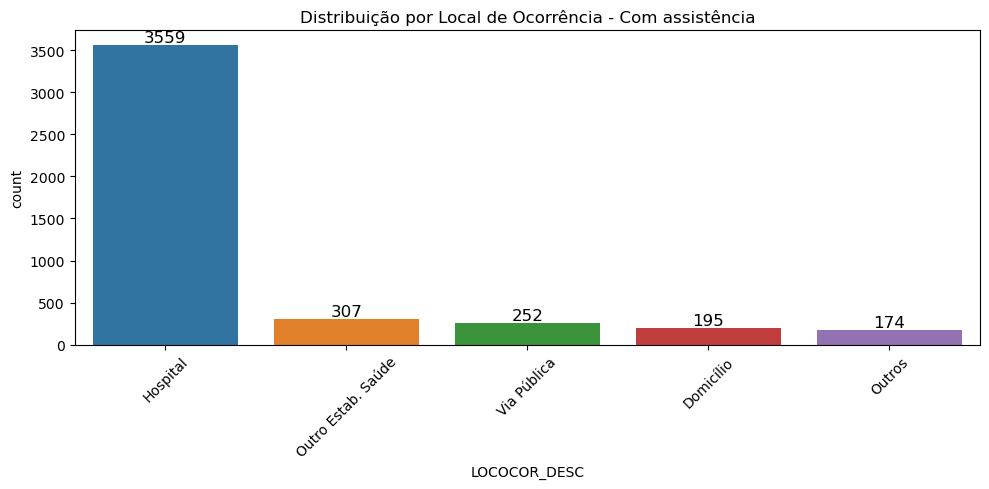

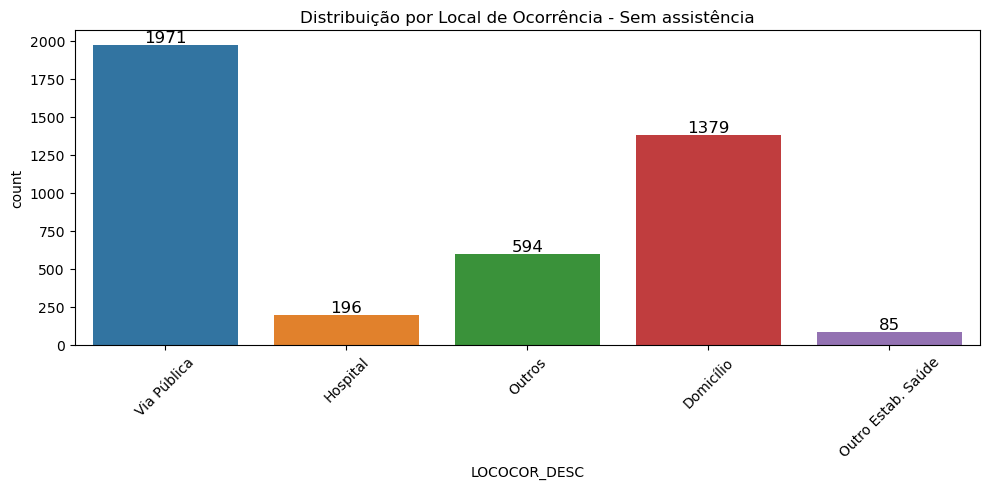

In [68]:
# Lista de categorias da assistência médica
tipos_assistencia = ['Com assistência', 'Sem assistência']

for tipo in tipos_assistencia:
    # Filtra registros com assistência atual e remove 'Ignorado' em LOCOCOR_DESC
    df_filtrado = df_resultado[
        (df_resultado['ASSISTMED_DESC'] == tipo) &
        (df_resultado['LOCOCOR_DESC'] != 'Ignorado')
    ]

    plt.figure(figsize=(10, 5))

    ax = sns.countplot(x=df_filtrado['LOCOCOR_DESC'])
    plt.title(f'Distribuição por Local de Ocorrência - {tipo}')

    # Rótulos no topo das barras
    for p in ax.patches:
        altura = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2,
            altura + 1,
            int(altura),
            ha='center', va='bottom',
            color='black', fontsize=12
        )

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
